In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import paired_distances
from sklearn.metrics import euclidean_distances

In [3]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding ='latin1')
    return dict

In [4]:
# Read input data
batch_1 = unpickle("data/data_batch_1")
batch_2 = unpickle("data/data_batch_2")
batch_3 = unpickle("data/data_batch_3")
batch_4 = unpickle("data/data_batch_4")
batch_5 = unpickle("data/data_batch_5")
test = unpickle("data/test_batch")
batch_meta = unpickle("data/batches.meta")
images = np.concatenate((batch_1['data'],batch_2['data'],batch_3['data'],batch_4['data'],batch_5['data'],test['data']))
images = np.transpose(images.reshape(60000,3,1024) ,axes=(0,2,1)).reshape(60000,3072)
labels = np.concatenate((batch_1['labels'],batch_2['labels'],batch_3['labels'],batch_4['labels'],batch_5['labels'],test['labels']))
label_names = batch_meta['label_names']

In [5]:
class PoCA():
    def __init__(self, dimension):
        self.dimension = dimension
    def transform(self, distance_matrix):
        self.sample_num = distance_matrix.shape[0]
        A = np.identity(self.sample_num)-1/self.sample_num * np.ones((self.sample_num,self.sample_num))
        # Get eigen vectors and eigne values for for -1/2*A*D*A.t
        sigma, U = np.linalg.eigh(-1/2 * A.dot(distance_matrix).dot(np.transpose(A)))
        idx = sigma.argsort()[::-1]
        # Y = U * sqrt(sigma)
        return U[:,idx][:,:self.dimension].dot(np.diag(np.sqrt(sigma[idx][:self.dimension])))

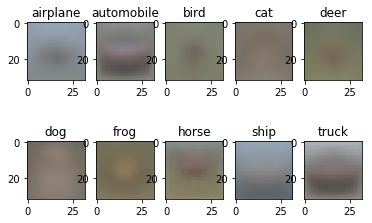

In [6]:
image_mean = []
for j in range(len(label_names)):
    image_mean.append(np.mean(images[np.array([i for i, e in enumerate(labels) if e == j])],axis=0))

#Visualize mean image for each class
for i in range(len(label_names)):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image_mean[i]/255).reshape(32,32,3))
    plt.title(label_names[i])

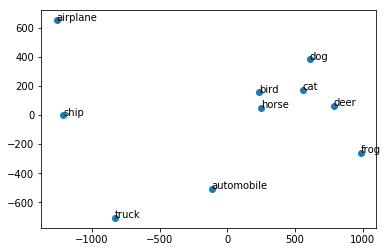

In [36]:
# Visualize distance of each class image into 2D scatter plot using PoCA
# Using Euclidean Distance between each pair of mean images
D = np.array(np.zeros((10,10)))
for i in range(10):
    for j in range(10):
        D[i][j] = (image_mean[i]-image_mean[j]).dot(np.transpose((image_mean[i]-image_mean[j]))) 
poca = PoCA(2)
Y = poca.transform(D)

fig, ax = plt.subplots()
ax.scatter(Y[:,0], Y[:,1])

for i, txt in enumerate(label_names):
    ax.annotate(txt, (Y[i][0], Y[i][1]))

In [11]:
# Visualize distance of each class image into 2D scatter plot using PoCA
# Using distance messure as explained below
pc_20 = []
pc_20_mean = []
for j in range(10):
    pca = PCA(20)
    pca.fit(images[np.array([i for i, e in enumerate(labels) if e == j])])
    pc_20.append(pca.components_ )
    pc_20_mean.append(pca.mean_)

C:\Users\rayso\AppData\Local\conda\conda\envs\tensorflow_env\lib\site-packages\sklearn\decomposition\pca.py:535: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


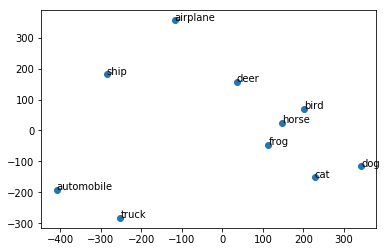

In [12]:
# Distance measured by (1/2)(E(A → B) + E(B → A))
# (E(A → B): average error obtained by representing all the images of class A using the mean of class A 
# and the first 20 principal components of class B
# Calculate E matrix
E=np.zeros((len(label_names),len(label_names)))
pca=PCA(20).fit(np.zeros((100,3072)))
for i in range(len(label_names)):
    for j in range(len(label_names)):
        pca.mean_ = image_mean[i]
        pca.components_ = pc_20[j]
        E[i][j] = np.mean(np.sum((pca.inverse_transform(pca.transform(images[np.array([m for m, e in enumerate(labels) if e == i])]))
                - images[np.array([m for m, e in enumerate(labels) if e == i])])**2,axis=1))

D2 = np.zeros((len(label_names),len(label_names)))
for i in range(10):
    for j in range(10):
        D2[i][j] = 0.5 * E[i][j] + 0.5 * E[j][i]
        
poca = PoCA(2)
Y = poca.transform(D2)

fig, ax = plt.subplots()
ax.scatter(Y[:,0], Y[:,1])

for i, txt in enumerate(label_names):
    ax.annotate(txt, (Y[i][0], Y[i][1]))

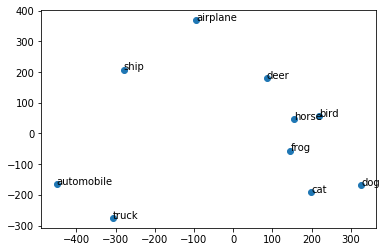

In [7]:
# Visualize distance of each class image into 2D scatter plot using PoCA
# Using distance messure as explained below
# Distance measured by (1/2)(E(A → B) + E(B → A))
# (E(A → B): average error obtained by representing all the images of class A using the mean of class B 
# and the first 20 principal components of class B
# Calculate E matrix
E=np.zeros((len(label_names),len(label_names)))
for i in range(len(label_names)):
    for j in range(len(label_names)):
        pca=PCA(20).fit(images[np.array([m for m, e in enumerate(labels) if e == j])])
        E[i][j] = np.mean(np.sum((pca.inverse_transform(pca.transform(images[np.array([m for m, e in enumerate(labels) if e == i])]))
                - images[np.array([m for m, e in enumerate(labels) if e == i])])**2,axis=1))
D3 = np.zeros((len(label_names),len(label_names)))
for i in range(10):
    for j in range(10):
        D3[i][j] = 0.5 * E[i][j] + 0.5 * E[j][i]
poca = PoCA(2)
Y = poca.transform(D3)

fig, ax = plt.subplots()
ax.scatter(Y[:,0], Y[:,1])

for i, txt in enumerate(label_names):
    ax.annotate(txt, (Y[i][0], Y[i][1]))          